In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import numpy as np


df = pd.read_csv('processed_data.csv')
df = df.drop(columns='loudness') ## drop loudness because it is highly correlated with energy

df['speechiness_log'] = np.log1p(df['speechiness'])  # log(1 + x) to handle zeros
df['instrumentalness_log'] = np.log1p(df['instrumentalness'])
df['liveness_log'] = np.log1p(df['liveness'])


clustering_features = ['danceability', 'energy', 'valence', 'tempo', 
                       'acousticness', 'speechiness_log', 'instrumentalness_log', 'liveness_log']

X = df[clustering_features]


## Sampling and Computing the Similarity Matrix

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Sample a smaller portion of the dataset
X_sample = X.sample(n=10000, random_state=42)  # Adjust n as needed

# Compute cosine similarity on the sample
similarity_matrix_sample = cosine_similarity(X_sample.values)



## Applying Spectral Clustering

In [20]:
from sklearn.cluster import SpectralClustering

# Set the number of clusters (adjust based on your needs)
n_clusters = 7  # Example, but you might adjust this based on your analysis

# Initialize Spectral Clustering with the precomputed similarity matrix
spectral_cluster = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
labels = spectral_cluster.fit_predict(similarity_matrix_sample)

# Add the cluster labels to the sampled DataFrame for analysis
X_sample['SpectralCluster'] = labels

# Check the distribution of clusters
print(X_sample['SpectralCluster'].value_counts())


SpectralCluster
0    3561
1    2256
2    1501
6    1135
4     926
3     611
5      10
Name: count, dtype: int64


 Shows the distribution of songs across clusters after applying Spectral Clustering. Each number represents the count of songs in a particular cluster.

In [21]:
# Group by Spectral Clusters to analyze features within each cluster
spectral_analysis = X_sample.groupby('SpectralCluster').mean()
print("Spectral Clustering Analysis:")
print(spectral_analysis)


Spectral Clustering Analysis:
                 danceability    energy   valence     tempo  acousticness  \
SpectralCluster                                                             
0                    0.665976  0.700967  0.737439  0.494005      0.254945   
1                    0.537352  0.762106  0.320453  0.553435      0.097744   
2                    0.522368  0.351600  0.353076  0.470419      0.772064   
3                    0.361973  0.175271  0.201590  0.437236      0.895199   
4                    0.514653  0.708402  0.449417  0.471829      0.360854   
5                    0.000000  0.000086  0.000000  0.000000      0.071788   
6                    0.583924  0.740928  0.324308  0.521142      0.100141   

                 speechiness_log  instrumentalness_log  liveness_log  
SpectralCluster                                                       
0                       0.081496              0.026584      0.151957  
1                       0.089374              0.024710      0.1

This analysis table provides a breakdown of the **average values** for various musical features within each **Spectral Cluster**. 

#### **Cluster 0**
- **Danceability**: 0.666 (moderate to high)
- **Energy**: 0.701 (high)
- **Valence**: 0.737 (high)
- **Acousticness**: 0.255 (moderate)
- **Speechiness_log**: 0.081 (low)
- **Instrumentalness_log**: 0.027 (very low)
  
**Conclusion**: Cluster 0 has high energy, danceability, and valence, indicating upbeat, lively, and positive-sounding songs. Low instrumentalness and speechiness suggest these are likely popular music tracks with vocals, possibly in genres like pop or upbeat electronic.

#### **Cluster 1**
- **Danceability**: 0.537 (moderate)
- **Energy**: 0.762 (high)
- **Valence**: 0.320 (low to moderate)
- **Acousticness**: 0.098 (very low)
  
**Conclusion**: Cluster 1 has high energy but lower valence, indicating intense or energetic tracks that may not be very “happy.” Low acousticness suggests an electronic or rock influence. This cluster might represent energetic but serious or darker-sounding tracks, possibly rock or EDM.

#### **Cluster 2**
- **Danceability**: 0.522 (moderate)
- **Energy**: 0.352 (low)
- **Valence**: 0.353 (moderate)
- **Acousticness**: 0.772 (high)
  
**Conclusion**: Cluster 2 shows moderate danceability, low energy, and high acousticness, which are typical of softer, more acoustic genres like folk or ballads. These songs may have a calming effect, likely representing mellow acoustic or singer-songwriter tracks.

#### **Cluster 3**
- **Danceability**: 0.362 (low)
- **Energy**: 0.175 (very low)
- **Valence**: 0.202 (low)
- **Acousticness**: 0.895 (very high)
- **Instrumentalness_log**: 0.618 (moderate to high)
  
**Conclusion**: Cluster 3 has very low danceability, energy, and valence, with high acousticness and instrumentalness. These characteristics suggest instrumental music with a calm or melancholic feel, possibly ambient or classical music.

#### **Cluster 4**
- **Danceability**: 0.515 (moderate)
- **Energy**: 0.708 (high)
- **Valence**: 0.449 (moderate)
- **Acousticness**: 0.361 (moderate)
- **Liveness_log**: 0.524 (high)
  
**Conclusion**: Cluster 4 has moderate danceability, high energy, and high liveness, which may indicate live recordings or songs with natural ambiance. It could represent energetic, live music or rock tracks with a slightly more acoustic sound.

#### **Cluster 5**
- **All Features Very Low**: Most feature values are close to 0, except for **instrumentalness_log** (0.465) and **liveness_log** (0.422).
  
**Conclusion**: Cluster 5 is likely an outlier or a group of very unique songs. With high instrumentalness and liveness, these could be experimental or minimalist tracks, possibly live recordings with sparse instrumentation or ambient noise.

#### **Cluster 6**
- **Danceability**: 0.584 (moderate to high)
- **Energy**: 0.741 (high)
- **Valence**: 0.324 (low to moderate)
- **Acousticness**: 0.100 (very low)
  
**Conclusion**: Cluster 6 has high energy and moderate danceability but lower valence, similar to Cluster 1 but with slightly more danceability. These could be dance tracks or high-energy songs that are a bit more neutral or serious, likely in genres like EDM or intense pop.

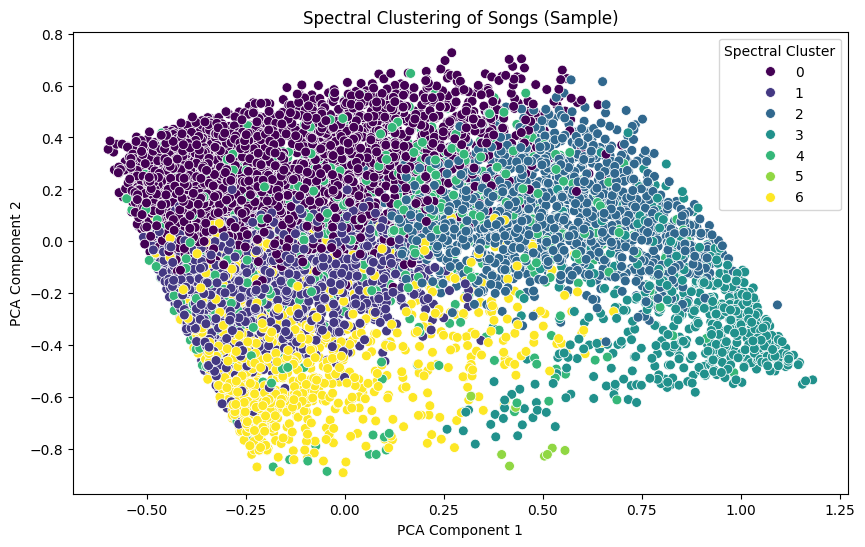

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample.drop(columns=['SpectralCluster'], errors='ignore'))

# Plot Spectral Clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X_sample['SpectralCluster'], palette="viridis", s=50)
plt.title("Spectral Clustering of Songs (Sample)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Spectral Cluster")
plt.show()



### Scatterplot of Spectral Clustering Results

The scatterplot above visualizes the **Spectral Clustering** results on a sample of songs. Each point represents a song, colored by its assigned cluster, and projected onto two dimensions using **PCA** for visualization.

- **Color-coded Clusters**: Each color indicates a distinct cluster, or "community" of songs, based on shared musical characteristics (e.g., energy, danceability).

- **Spatial Grouping**: Points of the same color tend to cluster together, showing that songs within the same cluster are similar in their feature profiles.

- **Distinct vs. Overlapping Clusters**:
  - Some clusters, like the yellow (Cluster 5), are spatially distinct, suggesting unique characteristics.
  - Other clusters, like the purple (Cluster 0) and blue (Cluster 1), are closer to each other, indicating some overlap in their musical features.




In [27]:

from sklearn.metrics import silhouette_score

# Set diagonal elements to zero
np.fill_diagonal(similarity_matrix_sample, 0)

# Calculate silhouette score for Spectral Clustering
score = silhouette_score(similarity_matrix_sample, labels, metric='precomputed')
print("Silhouette Score:", score)


Silhouette Score: -0.8098731691980269


### Silhouette Score Analysis

The **Silhouette Score** of **-0.81** indicates poor clustering quality for the Spectral Clustering results. This negative score suggests that clusters overlap significantly, with many points closer to points in other clusters than to those in their own.

The PCA scatterplot confirms this overlap, showing a lack of clear boundaries between clusters. .


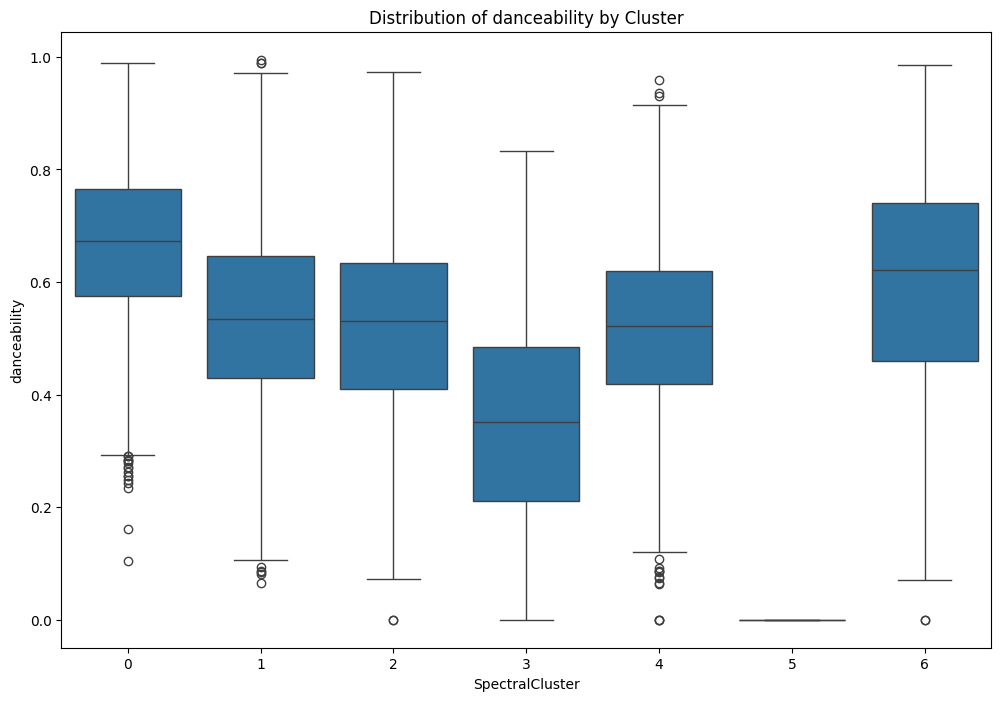

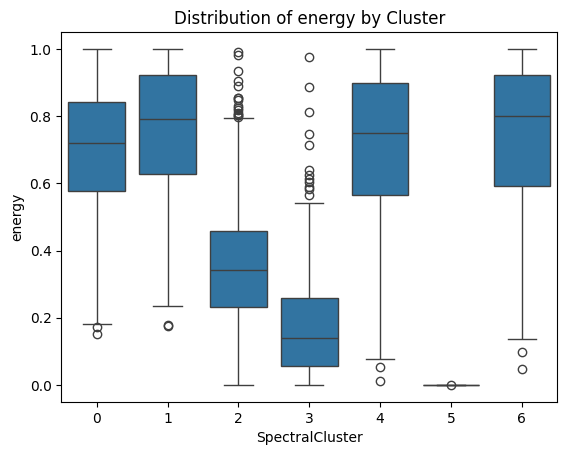

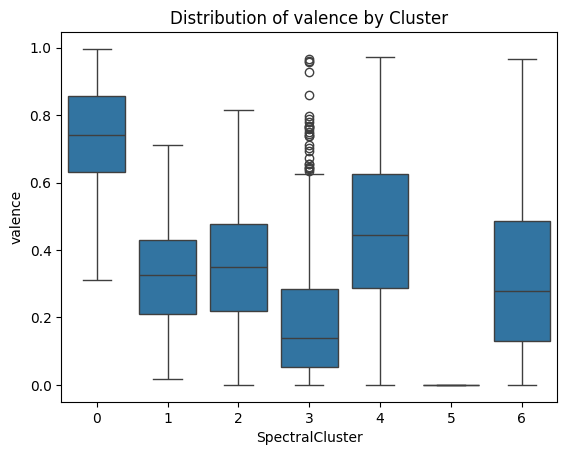

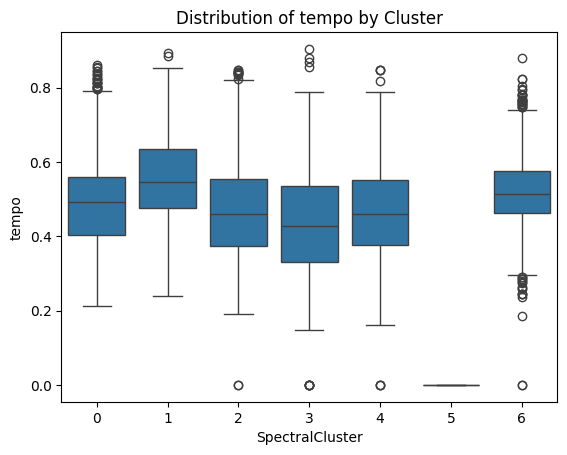

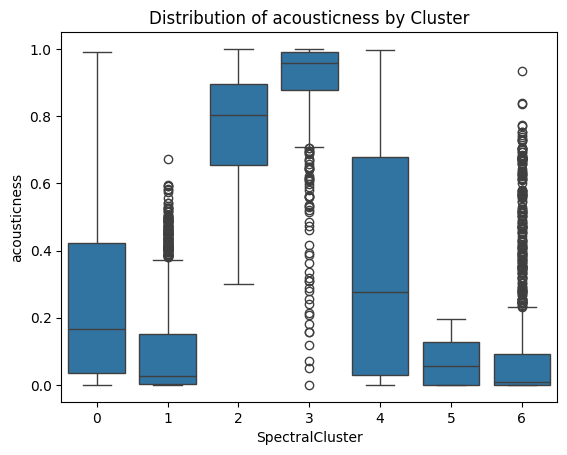

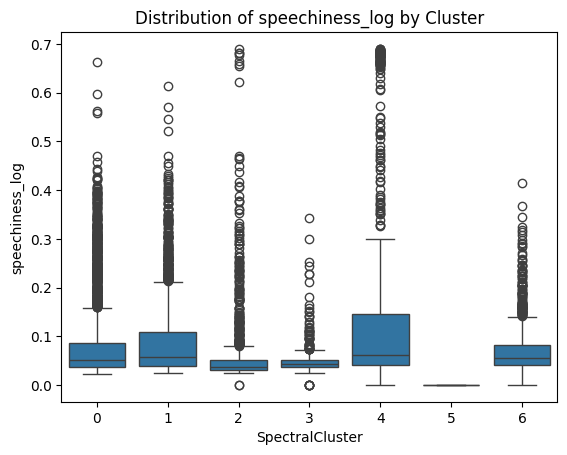

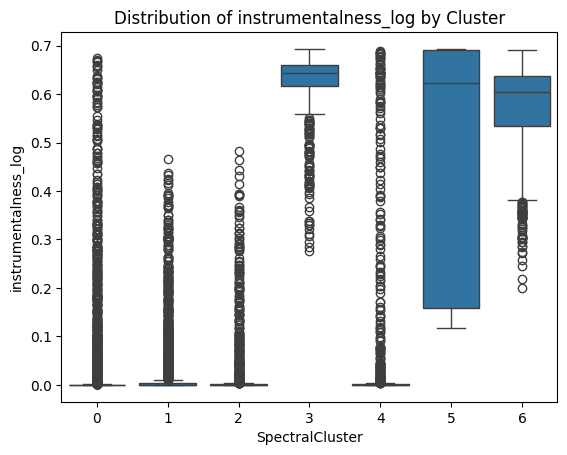

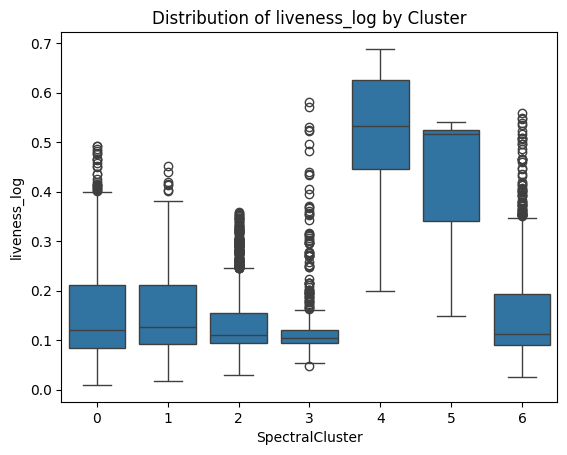

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for feature in clustering_features:
    sns.boxplot(x='SpectralCluster', y=feature, data=X_sample)
    plt.title(f"Distribution of {feature} by Cluster")
    plt.show()




### Observations based on the scatterplot

1. **Danceability**:
   - Clusters vary widely in danceability. Cluster 0 has a high median danceability, while Cluster 4 shows a more moderate spread. Cluster 5 has very low danceability, indicating it might contain songs that are not rhythmically suited for dancing.

2. **Energy**:
   - Cluster 1 and Cluster 6 have high energy distributions, while Cluster 3 has much lower energy. This suggests that Cluster 1 and 6 might contain intense, upbeat tracks, while Cluster 3 likely has calm or softer songs.

3. **Valence**:
   - Cluster 0 has a high valence, indicating positive or happy songs. Cluster 3 has a low valence, suggesting more melancholic or darker tones.

4. **Tempo**:
   - Tempo distribution is relatively uniform across clusters, with moderate variations. Cluster 5 has a low tempo, possibly indicating slower-paced tracks.

5. **Acousticness**:
   - Cluster 2 and Cluster 3 have high acousticness, indicating they contain more acoustic or natural sounds. In contrast, Clusters 1 and 6 have low acousticness, suggesting more electronic or synthesized sounds.

6. **Speechiness_log**:
   - Cluster 4 has a higher distribution of speechiness, which might include tracks with spoken word or rap elements.

7. **Instrumentalness_log**:
   - Cluster 5 and Cluster 6 have high instrumentalness, indicating they contain instrumental tracks, while other clusters are more vocal-centric.

8. **Liveness_log**:
   - Cluster 4 has high liveness, suggesting live recordings or tracks with audience sounds. Clusters 0 and 6 have lower liveness, indicating studio-produced songs.
